In [328]:
import random

#random.seed(420)
random.seed(1)

"""
- borrow_amount
- last_repaid
- total_staked
- total_locked
- staked

"""
maxBorrow = 1000000
maxRepaid = 60 * 60 * 24 * 60 # 60 days
overdue = maxRepaid * 0.75
stakers = [{"staked_amount": random.randint(25 * maxBorrow, 35 * maxBorrow) } for i in range(25)]

for i in range(len(stakers)):
    borrowers = [{"borrow_amount": random.randint(1, maxBorrow), "last_repaid": random.randint(1, maxRepaid)} for i in range(25)]
    stakers[i]["borrowers"] = borrowers
    stakers[i]["locked"] = sum([borrower["borrow_amount"] for borrower in borrowers])
    stakers[i]["frozen"] = sum([borrower["borrow_amount"] if borrower["last_repaid"] > overdue else 0 for borrower in borrowers])
    
total_staked = sum([staker["staked_amount"] for staker in stakers])
total_borrowed = sum([sum([borrower["borrow_amount"] for borrower in staker["borrowers"]]) for staker in stakers])
total_frozen = sum([staker["frozen"] for staker in stakers])

print(f"total_staked: {total_staked}")
print(f"total_borrowed: {total_borrowed}")
print(f"total_frozen: {total_frozen}")

total_staked: 735910771
total_borrowed: 323733531
total_frozen: 81588934


In [329]:
"""
Calculate multipliers the old way

function _getRewardsMultiplier(
    uint256 userStaked,
    uint256 lockedStake,
    uint256 totalFrozen_,
    bool isMember_
) private pure returns (uint256) {
    if (!isMember_) {
        return nonMemberRatio;
    }
        
    if (userStaked == 0 || totalFrozen_ >= lockedStake || totalFrozen_ >= userStaked) {
        return memberRatio;
    }

    uint256 effectiveLockedAmount = lockedStake - totalFrozen_;
    uint256 effectiveStakeAmount = userStaked - totalFrozen_;

    uint256 lendingRatio = effectiveLockedAmount.wadDiv(effectiveStakeAmount);

    return lendingRatio + memberRatio;
}

"""
member_ratio = 1

def getRewardsMultiplier(staked, locked_stake, frozen_stake):
    if staked == 0 or frozen_stake >= locked_stake or frozen_stake >= staked:
        return member_ratio
    
    effective_locked_amount = locked_stake - frozen_stake
    effective_stake_amount = staked - frozen_stake
    
    lending_ratio = effective_locked_amount / effective_stake_amount
    
    return lending_ratio + member_ratio

for staker in stakers:
    staker["old_multiplier"] = getRewardsMultiplier(staker["staked_amount"], staker["locked"], staker["frozen"])

In [334]:
"""
Calculate multipliers the new way

1 2 3 4 5 6 7 8 9
    |   |       |
    
(5 - 3) / (9 - 3) = 0.16666
"""
import math

# first we calculate each stakers coinage
for staker in stakers:
    staker["coinage"] = sum([borrower["borrow_amount"] * borrower["last_repaid"] for borrower in staker["borrowers"]])

total_coinage = sum([staker["coinage"] for staker in stakers])
print(f"total_coinage: {total_coinage}")

def getRewardsMultiplierNew(coinage, staked, locked):
    # TODO: what about staked vs total staked
    # TODO: what about locked value
    ave_coinage = total_coinage / len(stakers)
    lo = ave_coinage - ave_coinage
    hi = ave_coinage + ave_coinage
    coinage = min(max(lo, coinage), hi)
    
    k = ((coinage - lo) / (hi - lo))
    j = locked / staked
    
    print(j, k)
    
    return 2 * ((j+k)/2)
    
for staker in stakers:
    staker["new_multiplier"] = getRewardsMultiplierNew(staker["coinage"], staker["staked_amount"], staker["locked"])

total_coinage: 833980521206373
0.5840966055321193 0.641152853206473
0.3782039682247488 0.602340479125328
0.4899561206989313 0.4947658870413457
0.3407637014321494 0.35671733239036363
0.4659752504480723 0.4473923528812944
0.40575262605652174 0.5659955524295378
0.44032486439962526 0.534027868215286
0.3020218716664601 0.4176676284223186
0.353318476148627 0.5631280926319567
0.4466797513271735 0.4010740996427501
0.5012060342200639 0.510311270138674
0.4114761194225948 0.5795715699312233
0.5822458054064379 0.5206803809614494
0.410228235937038 0.44037800660095433
0.4026925267972171 0.5180067096962027
0.6248580356410678 0.5958837203808333
0.35336289262895204 0.43309475621034427
0.5147253394624085 0.6165549413745656
0.3938098951615669 0.43977659198038327
0.3268705845722487 0.33713590221098727
0.47408623449364024 0.5320765741010559
0.3547664125852807 0.3886901236054437
0.4674121418022833 0.5461682787555605
0.5819146322556399 0.5928950676121876
0.586428276184562 0.4245139604534801


diffs: 3
----
IDX:1 staked: 26978347, locked: 12571242, frozen: 3333477, old_mul: 1.39, new_mul: 0.91
IDX:0 staked: 29279348, locked: 9977339, frozen: 1472949, old_mul: 1.31, new_mul: 0.70
----
IDX:1 staked: 28522457, locked: 12740404, frozen: 2752579, old_mul: 1.39, new_mul: 0.85
IDX:0 staked: 31368886, locked: 11083207, frozen: 4470980, old_mul: 1.25, new_mul: 0.92
----
IDX:1 staked: 32260626, locked: 12991113, frozen: 3882743, old_mul: 1.32, new_mul: 0.92
IDX:0 staked: 31539906, locked: 12938560, frozen: 881768, old_mul: 1.39, new_mul: 0.85
----


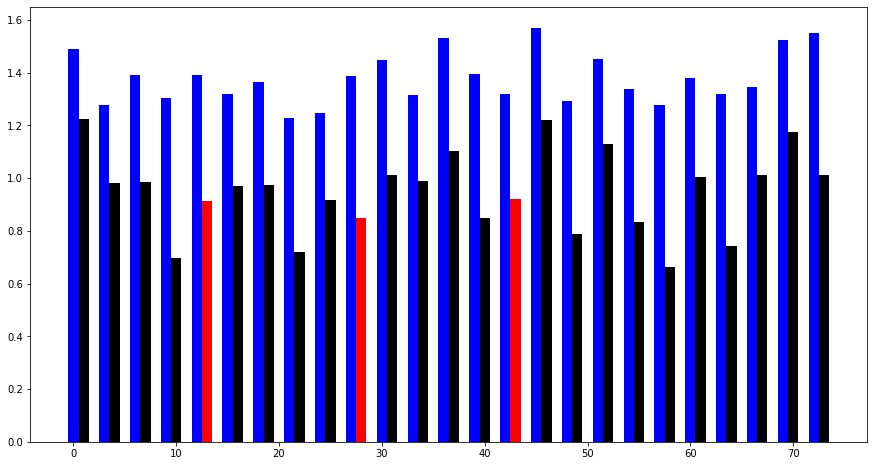

In [335]:
import matplotlib.pyplot as plt

debug = False
plt.figure(figsize=(15,8))

diffs=[]
step = 3
for i in range(0, len(stakers) * 3, step):
    idx = int(i/step)
    
    old = stakers[idx]['old_multiplier']
    old_b = stakers[idx-step]['old_multiplier']

    new = stakers[idx]['new_multiplier']
    new_b = stakers[idx-step]['new_multiplier']
    
    color="black"
    if (old > old_b and new < new_b) or (old < old_b and new > new_b):
        diffs.append({ "c": stakers[idx], "p": stakers[idx-1]})
        color="red"
            
    plt.bar(i, old, 1, color="blue")
    plt.bar(i+1, new, 1, color=color)
    if debug:
        print("------")
        print(f"old_multiplier: {staker['old_multiplier']}")
        print(f"new_multiplier: {staker['new_multiplier']}")

print(f"diffs: {len(diffs)}")
print("----")
for diff in diffs:
    print(f"IDX:1 staked: {diff['c']['staked_amount']}, locked: {diff['c']['locked']}, frozen: {diff['c']['frozen']}, old_mul: {diff['c']['old_multiplier']:.2f}, new_mul: {diff['c']['new_multiplier']:.2f}")
    print(f"IDX:0 staked: {diff['p']['staked_amount']}, locked: {diff['p']['locked']}, frozen: {diff['p']['frozen']}, old_mul: {diff['p']['old_multiplier']:.2f}, new_mul: {diff['p']['new_multiplier']:.2f}")
    print("----")